## 1.) Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_loader.load import load_pd, load
from datetime import datetime
import csv
import os.path
import json
from collections import defaultdict
import mplcyberpunk
plt.style.use("cyberpunk")

## 2.) Read Data

In [20]:
main_data18 = load_pd("../data/kd2018.csv", ";")
main_data19 = load_pd("../data/kd2019.csv", ";")
main_data20 = load_pd("../data/kd2020.csv", ";")
main_data21 = load_pd("../data/kd2021.csv", ";")

### 2.1 Priprava podatkov
V podatkih je nek zločin zapisan večrat. To je ocitno, saj se zaporedna številka kaznivega dejanja ponavlja večrat.

In [21]:
main_data18_filtered = main_data18.drop_duplicates(["ZaporednaStevilkaKD"])
main_data19_filtered = main_data19.drop_duplicates(["ZaporednaStevilkaKD"])
main_data20_filtered = main_data20.drop_duplicates(["ZaporednaStevilkaKD"])
main_data21_filtered = main_data21.drop_duplicates(["ZaporednaStevilkaKD"])

np.warnings.filterwarnings('ignore')
main_data19_filtered["ZaporednaStevilkaKD"] += main_data18_filtered["ZaporednaStevilkaKD"].max()
main_data20_filtered["ZaporednaStevilkaKD"] += main_data19_filtered["ZaporednaStevilkaKD"].max()
main_data21_filtered["ZaporednaStevilkaKD"] += main_data20_filtered["ZaporednaStevilkaKD"].max()

In [22]:
main_data = pd.concat([main_data18_filtered, main_data19_filtered, main_data20_filtered, main_data21_filtered])

In [36]:
dict_obcina_regija = json.load(open("../data/obcina_regija.json"))

## 3.) Analiza kriminala glede na kraj dogodka

In [23]:
dataset_place_types: np.array = main_data["OpisKraja"].unique()

### 3.1 Število KD glede na opis kraja

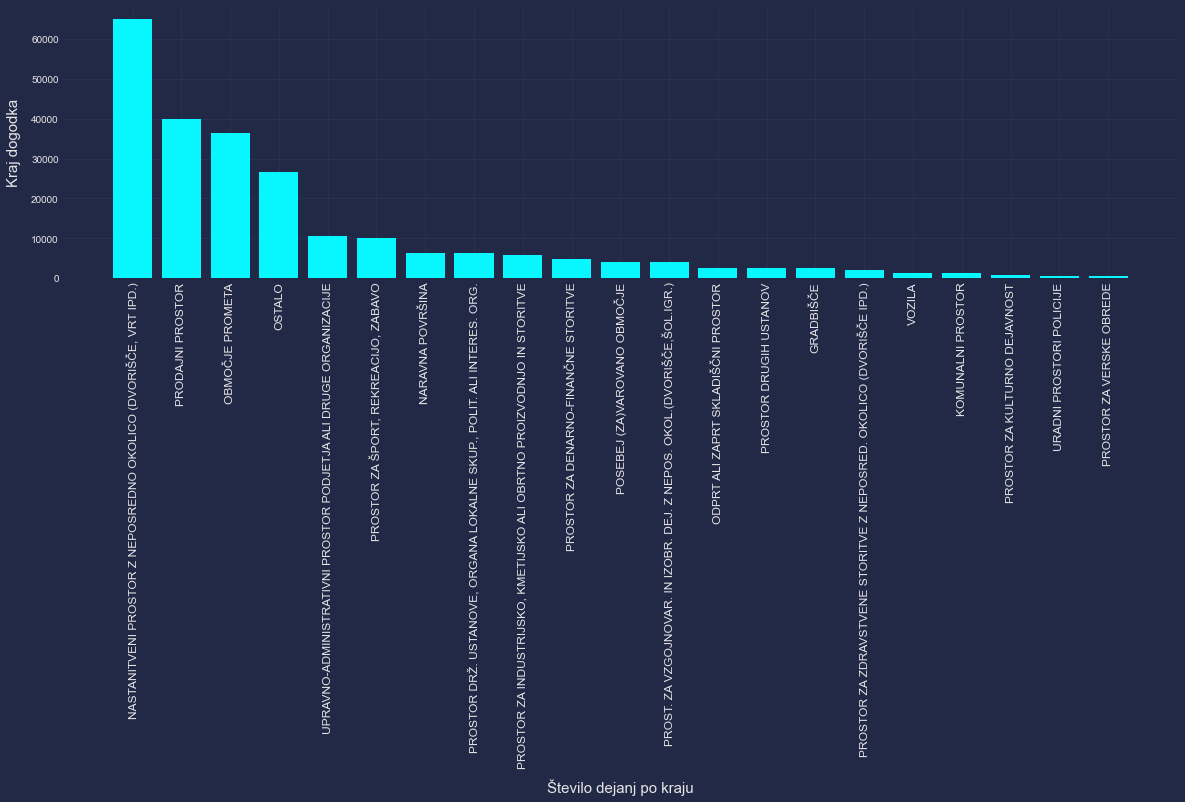

In [24]:
plt.figure(figsize=(20, 5))
count_by_opis_kraja = main_data.groupby("OpisKraja")["OpisKraja"].count().sort_values(ascending=False)
plt.bar(count_by_opis_kraja.index, count_by_opis_kraja.values)
plt.xticks(count_by_opis_kraja.index, rotation=90, fontsize=12)
plt.xlabel('Število dejanj po kraju', fontsize=15, labelpad=10)
plt.ylabel('Kraj dogodka', fontsize=15, labelpad=10)

plt.show()

### 3.2 Odstranitev OSTALO
Nekatera kazniva dejanja imajo za opis kraja vnešeno OSTALO.  
Ker nam to ne pove nič o kraju bom iz main_data odstranil vsa kazniva dejanja, ki imajo za opis kraja OSTALO.

In [25]:
main_data = main_data.query("OpisKraja != 'OSTALO'")
dataset_place_types = np.delete(dataset_place_types, dataset_place_types == "OSTALO")
#nan value
dataset_place_types = np.delete(dataset_place_types, -2)

### 3.3 Nevarnost stavb

Nevarnost stavb je odvisna od ocene nevarnosti kaznivih dejanj, ki se dogajajo v nekem tipu stavbe.  
To oceno lahko izračunam s pomočjo kazni_dict, podobno kot v `data_processing/varnost_posameznih_regij.ipynb`.  
Poleg tega pa je odvisna še od splošne nevarnosti občine kjer se je zgodilo KD v nekem tipu stavbe.

### 3.3.4 Ocena nevarnosti tipa stavbe

In [26]:
# read json data from kazni_dict.json
with open('../data/kazni_dict.json', 'r', encoding='utf8') as f:
    kazni_dict = json.load(f)

kazni_utezi = dict()
for kd, values in kazni_dict.items():
        if (pd.isna(values['average_actual_jailtime'])):
            x = values['max_jailtime'] * 2 * values['dangerousness']
        else:
            x = (values['max_jailtime'] + values['average_actual_jailtime']) * values['dangerousness']
        kazni_utezi[kd] = x

In [27]:
nevarnost_by_stavba: dict = dict.fromkeys(dataset_place_types, 0)
kd_errors_dict = defaultdict(int)


for i, kd in main_data.iterrows():
    place = kd["OpisKraja"]
    kd = str.lower(str.strip(str.split(kd["OpisKD"], '-')[-1]))

    try:
        nevarnost_by_stavba[place] += kazni_utezi[kd]
    except KeyError:
        kd_errors_dict[kd] += 1
        # print(f"NAPAKA PRI \"PLACE: {place}, KD: {kd}\"")

# kd_errors = np.array(list(kd_errors_dict.items()), dtype=object)
# kd_errors = kd_errors[np.argsort(kd_errors[:, 1])[::-1]]
# kd_errors

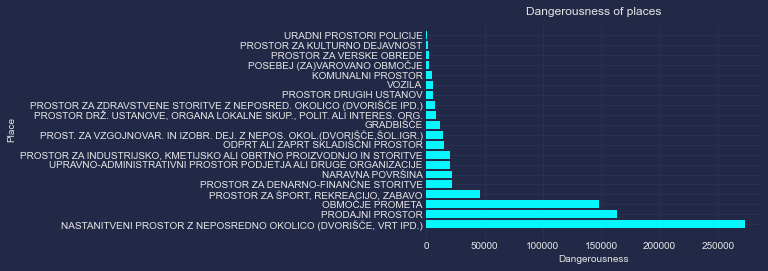

In [28]:
np_place_danger = np.array(list(nevarnost_by_stavba.items()), dtype=object)
np_place_danger = np_place_danger[np.argsort(np_place_danger[:, 1])[::-1]]
# print(np_regije_danger)
# create graph of dangerousness of regions

fig, ax = plt.subplots()
ax.barh(np_place_danger[:, 0], np_place_danger[:, 1])
ax.set_xlabel('Dangerousness')
ax.set_ylabel('Place')
ax.set_title('Dangerousness of places')
plt.show()

In [29]:
formated_opis_kd = main_data["OpisKD"].apply(lambda x: str.lower(str.strip(str.split(x, '-')[-1])))
formated_kd_main_data = main_data.copy()
formated_kd_main_data["OpisKD"] = formated_opis_kd
# formated_kd_main_data.where(formated_kd_main_data["OpisKraja"] == 'POSEBEJ (ZA)VAROVANO OBMOČJE').groupby("OpisKD")["OpisKD"].count().sort_values(ascending=False)
formated_kd_main_data.where(formated_kd_main_data["OpisKraja"] == 'OBMOČJE PROMETA').groupby("OpisKD")["OpisKD"].count().sort_values(ascending=False)

OpisKD
tatvina                                                                                                 14759
velika tatvina                                                                                           6222
poškodovanje tuje stvari                                                                                 5941
neupravičena proizvodnja in promet s prepovedanimi drogami, nedovoljenimi snovmi v športu in predhod     1426
zatajitev                                                                                                1182
                                                                                                        ...  
protipravno zavzetje nepremičnine                                                                           1
tihotapstvo                                                                                                 1
napad na varnost zračnega prometa                                                                           1
neo

In še normalizacija glede na najvišjo nevarnost:

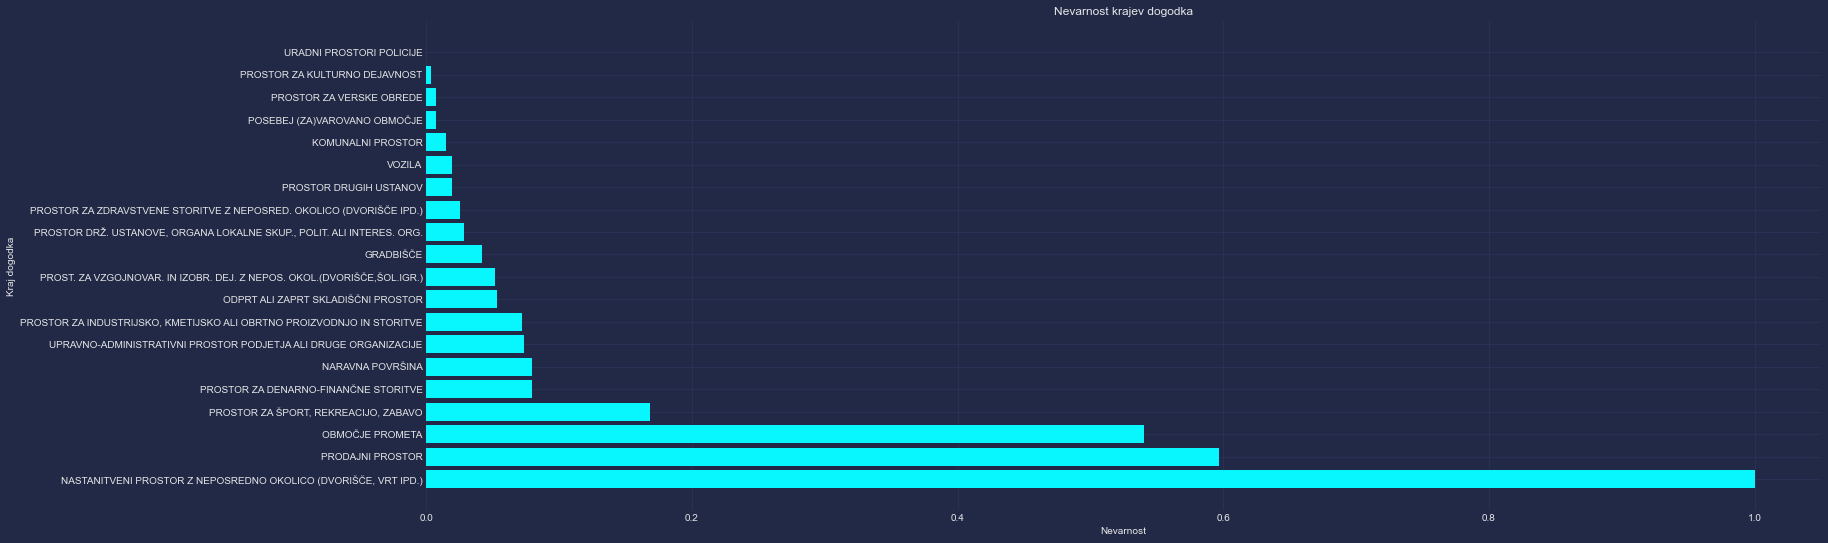

In [33]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

    
normalized_place_danger: np.array = np.array(np_place_danger, dtype=object)
normalized_place_danger[:, 1] = normalize(normalized_place_danger[:,1], 0, 1)

fig, ax = plt.subplots(figsize=(25, 9))
ax.barh(normalized_place_danger[:, 0], normalized_place_danger[:, 1])
ax.set_xticks(normalized_place_danger[:, 0])
ax.set_xlabel('Nevarnost')
ax.set_ylabel('Kraj dogodka')
ax.set_title('Nevarnost krajev dogodka')
plt.show()

### 3.4 Nevarnost stavbe v občini
$nevarnost_{stavbe} * nevarnost_{občine}$

### 4. Save the results

In [13]:
#json.dump({place: danger for place, danger in normalized_place_danger}, open('../data/place_danger.json', 'w'), ensure_ascii=False)

## X.) Place types from google places API
I want to map "OpisKraja" from our dataset to specific place types of the places API.

## Ugotovitve
- POSEBEJ (ZA)VAROVANO OBMOČJE je z veliko verjetnostjo nek drug/organized crime operation, 
  - Je pa res da vsaj umorov pa takih stvari ni. Tudi tatvin ne...
- Največ težkega crime-a zgleda da je doma.
- V prometu je velik tatvine/velike tatvine, drug busts... all the good stuff